In [1]:
import numpy as np
import pandas as pd
import requests
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import plotly.express as px

In [3]:
# Premier league stats url
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
# Player stats url
url_player_data = 'https://fantasy.premierleague.com/api/element-summary/'

In [4]:
def get(url):
    response = requests.get(url)
    return json.loads(response.content)

In [5]:
response = get(url)
print(response.keys())

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])


In [6]:
print(response['events'][0].keys())
df = pd.DataFrame(response['events'])
df = df[['id', 'name','average_entry_score', 'highest_score']].dropna()
df.head()

dict_keys(['id', 'name', 'deadline_time', 'average_entry_score', 'finished', 'data_checked', 'highest_scoring_entry', 'deadline_time_epoch', 'deadline_time_game_offset', 'highest_score', 'is_previous', 'is_current', 'is_next', 'chip_plays', 'most_selected', 'most_transferred_in', 'top_element', 'top_element_info', 'transfers_made', 'most_captained', 'most_vice_captained'])


,id,name,average_entry_score,highest_score
0,1,Gameweek 1,50,142.0
1,2,Gameweek 2,59,165.0
2,3,Gameweek 3,43,119.0
3,4,Gameweek 4,48,160.0
4,5,Gameweek 5,60,136.0


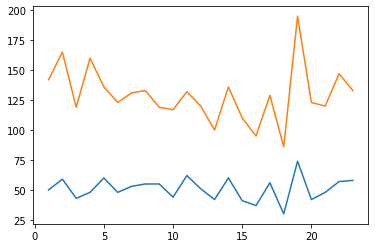

In [7]:
gameweek = df['id']
average_score = df['average_entry_score']
mean_avg_score = np.mean(average_score)
highest_score = df['highest_score']

fig, ax = plt.subplots()
ax.plot(gameweek, average_score)
ax.plot(gameweek, highest_score)

In [8]:
players_df = pd.DataFrame(response['elements'])

In [9]:
print(response['elements'][0].keys())
players_df = pd.DataFrame(response['elements'])
# players_df = players_df[['id', 'team_code', 'team','first_name', 'second_name', 'minutes', 'goals_scored', 
#                          'assists', 'clean_sheets','points_per_game', 'ict_index', 'now_cost', 'cost_change_start','cost_change_start_fall','transfers_out_event']]

dict_keys(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank', 'creativity_rank_type', 'threat_rank', 'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type', 'corners_and_indirect_fr

In [10]:
# players_df.sort_values(['goals_scored'], ascending=False).head(15)

In [11]:
# Fixture Difficulty

In [12]:
# PL Stats API URL
url_pl_stats = 'https://fantasy.premierleague.com/api/bootstrap-static/'
# Fixtures Info
url_fixtures = ' https://fantasy.premierleague.com/api/fixtures/'

# Teams DataFrame
response = get(url_pl_stats)
teams_df = pd.DataFrame(response['teams'])
# fixtures DataFrame
fixtures = get(url_fixtures)
fixtures_df = pd.DataFrame(fixtures)

In [13]:
def teamId_to_teamName(teams_df, team_id):
    name = teams_df.loc[teams_df['id'] == team_id,  'name'][team_id - 1]
    return name

def elementType_to_PlayerPosition(element_type):
    position_dict = {1: "GKP", 
                     2: "DEF", 
                     3: "MID", 
                     4: "FWD"}
    return position_dict[element_type]

In [14]:
def fixture_difficulty(team_id, fixtures_df):
    """
    get fixture difficulty for team in the next 5 matches
    team_id: id of the team
    fixtures_df: fixtures DataFrame
    """
    newdf = fixtures_df[(fixtures_df.finished == False) & 
                        ((fixtures_df.team_h == team_id) | (fixtures_df.team_a == team_id))]
    newdf = newdf.head(5)

    fixture_difficulty_list = []
    opposition = []
    event = []
    
    for idx in newdf.index:
        if newdf['team_h'][idx] == team_id:
            fixture_difficulty_list.append(newdf['team_h_difficulty'][idx])
            opposition.append(newdf['team_a'][idx])
            event.append(newdf['event'][idx])
            
        elif newdf['team_a'][idx] == team_id:
            fixture_difficulty_list.append(newdf['team_a_difficulty'][idx])
            opposition.append(newdf['team_h'][idx])
            event.append(newdf['event'][idx])
#     print(event)        
#     print(opposition)        
    return fixture_difficulty_list, opposition

In [15]:
def team_upcoming_fixture_difficulty(fixtures_df, teams_df):
    """
    returns DataFrame containing every team's average fixture difficulty 
    over next 5 fixtures.
    """
    # unique team_code
    teams = teams_df.id.unique()
    mean_difficulty_array = []
    for team in teams:
        
        #get team name 
        name = teamId_to_teamName(teams_df, team)
        
        # list of 5 fixture difficulty
        lst, opposition = fixture_difficulty(team, fixtures_df)
        lst = np.array(lst)
        
        opposition = [teamId_to_teamName(teams_df, x) for x in opposition]
        
        # Calculate average
        mean_difficulty = round(np.mean(lst),2)
        mean_difficulty_array.append([team, name, opposition, mean_difficulty])
    
    df = pd.DataFrame(mean_difficulty_array, columns =['team_code', 'team_name', 'upcoming fixtures', 'mean_difficulty']) 
    return df

In [16]:
lst = fixture_difficulty(1, fixtures_df)
difficulty_df = team_upcoming_fixture_difficulty(fixtures_df, teams_df)
difficulty_df.sort_values(['mean_difficulty'], ascending= True).head(20)

,team_code,team_name,upcoming fixtures,mean_difficulty
5,6,Crystal Palace,"[Burnley, Brighton, Fulham, Spurs, West Brom]",2.4
17,18,West Brom,"[Man Utd, Burnley, Brighton, Newcastle, Crysta...",2.6
3,4,Burnley,"[Crystal Palace, Fulham, West Brom, Spurs, Ars...",2.8
10,11,Liverpool,"[Leicester, Everton, Sheffield Utd, Fulham, Wo...",2.8
8,9,Leicester,"[Liverpool, Aston Villa, Arsenal, Brighton, Sh...",2.8
7,8,Fulham,"[Spurs, Everton, Burnley, Sheffield Utd, Cryst...",2.8
9,10,Leeds,"[Arsenal, Wolves, Southampton, Aston Villa, We...",3.0
16,17,Spurs,"[Aston Villa, Fulham, Man City, West Ham, Burn...",3.0
19,20,Wolves,"[Southampton, Leeds, Newcastle, Aston Villa, L...",3.0
4,5,Chelsea,"[Newcastle, Southampton, Man Utd, Everton, Leeds]",3.0


In [17]:
# could potentially add form coloum as well for every team

In [18]:
#more metrics: ownership, transfer_in, transfer_out, suspension threat

In [19]:
# Player stats url
url_player_data = 'https://fantasy.premierleague.com/api/element-summary/'
print(response['elements'][0].keys())
players_df = pd.DataFrame(response['elements'])

dict_keys(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank', 'creativity_rank_type', 'threat_rank', 'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type', 'corners_and_indirect_fr

In [20]:
# suspension threat

suspend_df = players_df[['first_name', 'second_name', 'element_type', 'team', 
                         'yellow_cards']].sort_values(['yellow_cards'], ascending= False)
suspend_df.head(10)

,first_name,second_name,element_type,team,yellow_cards
589,Conor,Gallagher,3,18,7
10,Héctor,Bellerín,2,1,7
445,Isaac,Hayden,3,14,6
401,Harry,Maguire,2,13,6
473,John,Egan,2,15,6
147,N'Golo,Kanté,3,5,6
85,Yves,Bissouma,3,3,6
178,Luka,Milivojevic,3,6,6
265,Jonny,Evans,2,9,6
287,Nampalys,Mendy,3,9,5


In [21]:
#transfer in and out
player_in = players_df[['first_name', 'second_name', 'element_type', 
                        'team', 'transfers_in_event', 'status']].sort_values(['transfers_in_event'], ascending= False)

player_out = players_df[['first_name', 'second_name', 'element_type', 
                        'team', 'transfers_out_event', 'status']].sort_values(['transfers_out_event'], ascending= False)

player_out.head(10)

,first_name,second_name,element_type,team,transfers_out_event,status
457,Callum,Wilson,4,14,585307,i
618,Tomas,Soucek,3,19,308082,a
607,Michail,Antonio,4,19,186122,d
536,Heung-Min,Son,3,17,166959,a
181,Wilfried,Zaha,3,6,150514,i
277,James,Maddison,3,9,127833,a
43,Jack,Grealish,3,2,122138,a
339,Mohamed,Salah,3,11,113025,a
340,Andrew,Robertson,2,11,111681,a
158,Benjamin,Chilwell,2,5,109993,a


In [22]:
# cost change 
cost_change_df = players_df[['first_name', 'second_name', 'element_type', 
                        'team', 'cost_change_event', 'cost_change_event_fall', 'selected_by_percent']]

cost_change_df['selected_by_percent'] = [float(cost_change_df['selected_by_percent'][idx])
                                         for idx in cost_change_df.index]

cost_change_df = (cost_change_df[(cost_change_df.
                                  cost_change_event != 0)]).sort_values(['selected_by_percent'], ascending=False)

cost_change_df.head()

<ipython-input-22-f95205a1cdf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_change_df['selected_by_percent'] = [float(cost_change_df['selected_by_percent'][idx])


,first_name,second_name,element_type,team,cost_change_event,cost_change_event_fall,selected_by_percent
536,Heung-Min,Son,3,17,-1,1,54.3
302,Patrick,Bamford,4,10,1,-1,50.7
211,Dominic,Calvert-Lewin,4,7,1,-1,44.3
339,Mohamed,Salah,3,11,-1,1,43.5
363,Ilkay,Gündogan,3,12,1,-1,26.7


In [23]:
# Average Points/game vs cost

df = players_df[['first_name', 'second_name', 'element_type', 'now_cost', 'points_per_game', 'minutes',
                 'goals_scored', 'assists', 'clean_sheets', 'selected_by_percent']]

newdf = (df[df.minutes >= (90*5)]).sort_values(['points_per_game'], ascending= False)
newdf.head()

,first_name,second_name,element_type,now_cost,points_per_game,minutes,goals_scored,assists,clean_sheets,selected_by_percent
534,Harry,Kane,4,110,7.5,1744,13,11,7,20.7
404,Bruno Miguel,Borges Fernandes,3,115,7.3,1925,13,11,8,59.4
339,Mohamed,Salah,3,126,7.0,1831,16,4,5,43.5
536,Heung-Min,Son,3,96,7.0,1886,13,6,9,54.3
365,John,Stones,2,52,6.5,1170,2,0,10,21.0


In [24]:
d = newdf[['first_name', 'second_name','points_per_game', 'now_cost', 'element_type', 'selected_by_percent']]

d['points_per_game'] = [float(d['points_per_game'][idx])for idx in d.index]
d['element_type'] = [elementType_to_PlayerPosition(d['element_type'][idx]) for idx in d.index]

<ipython-input-24-0f4a70a6b576>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['points_per_game'] = [float(d['points_per_game'][idx])for idx in d.index]
<ipython-input-24-0f4a70a6b576>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['element_type'] = [elementType_to_PlayerPosition(d['element_type'][idx]) for idx in d.index]


In [ ]:
fig = px.scatter(d, x="now_cost", y="points_per_game", color="element_type",  hover_data=['second_name'])

app = dash.Dash()
app.layout = html.Div([
    html.Div([dcc.Graph(id='graphid', figure= fig)], 
             style={'width':'50%','display':'inline-block'}),
    
    html.Div([dcc.Markdown(id= 'player-metrics')
             ], style={'width':'20%','display':'inline-block'})
])


@app.callback(
    Output('player-metrics', 'children'), 
    [Input('graphid', 'hoverData')])
def player_stats(hoverdata):
    df_index = hoverdata['points'][0]['pointIndex']
    stats = """ Name: {} \n
                Cost: {} \n
                PPG: {} \n
                Own: {} \n""".format(d.iloc[df_index]['first_name'] + ' '+ d.iloc[df_index]['second_name'], 
                                       d.iloc[df_index]['now_cost'],
                                       d.iloc[df_index]['points_per_game'],
                                       d.iloc[df_index]['selected_by_percent'])
    return json.dumps(hoverdata)
#       return json.dumps(hoverData, indent=2)
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [12/Feb/2021 10:57:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_0m1611645439.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_0m1611645439.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_0m1611645439.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_0m1611645439.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_2m1611645439.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:08] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_15_0m1611645439.min.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/dash/dash.py", line 1078, in dispatch
    response.set_d

127.0.0.1 - - [12/Feb/2021 10:57:09] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [12/Feb/2021 10:57:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 10:57:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [12/Feb/2021 11:03:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 11:03:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/dash/dash.py", line 1078, in dispatch
    response.set_d

127.0.0.1 - - [12/Feb/2021 12:40:46] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [12/Feb/2021 12:40:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Feb/2021 12:41:35] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
# # fig = px.scatter(d, x="now_cost", y="points_per_game", color="element_type", 
# #                  hover_data=['second_name'])

# app = dash.Dash()
# app.layout = html.Div([
#     html.Div([dcc.Graph(id='graphid',
#          figure={
#              'data':[go.Scatter(
#              x=d['now_cost'],
#              y=d['points_per_game'],
#              text= d['second_name'],
#              name = 'players',
#              mode='markers'
#              )],
             
#              'layout':go.Layout(
#                  title='Cost vs PPG',
#                  xaxis={'title':'Cost'},
#                  yaxis={'title':'PPG'},
#                  hovermode= 'closest', showlegend= True)
#          })
#          ], style={'width':'50%','display':'inline-block'}),
    
#     html.Div([dcc.Markdown(id= 'player-metrics')
#              ], style={'width':'20%','display':'inline-block'})
# ])


# @app.callback(
#     Output('player-metrics', 'children'), 
#     [Input('graphid', 'hoverData')])
# def player_stats(hoverdata):
#     df_index = hoverdata['points'][0]['pointIndex']
#     stats = """ Name: {} \n
#                 Cost: {} \n
#                 PPG: {} \n
#                 Own: {}""".format(d.iloc[df_index]['first_name'] + ' '+ d.iloc[df_index]['second_name'], 
#                                        d.iloc[df_index]['now_cost'],
#                                        d.iloc[df_index]['points_per_game'],
#                                        d.iloc[df_index]['selected_by_percent'])
#     return stats

# if __name__ == '__main__':
#     app.run_server()